In [16]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

# Load control and experiment CSVs
experiment = pd.read_csv("/Users/rohityadav/Desktop/Git Projects/ml-abtest-udacity/data/Final Project Results - Experiment.csv")
control = pd.read_csv("/Users/rohityadav/Desktop/Git Projects/ml-abtest-udacity/data/Final Project Results - Control.csv")

# Tag each group
control["Group"] = "control"
experiment["Group"] = "experiment"

#Combine into one dataframe
df = pd.concat([control, experiment], ignore_index = True)

#Take a peek at the data
df.head(15)

,Date,Pageviews,Clicks,Enrollments,Payments,Group
0,"Sat, Oct 11",7723,687,134.0,70.0,control
1,"Sun, Oct 12",9102,779,147.0,70.0,control
2,"Mon, Oct 13",10511,909,167.0,95.0,control
3,"Tue, Oct 14",9871,836,156.0,105.0,control
4,"Wed, Oct 15",10014,837,163.0,64.0,control
5,"Thu, Oct 16",9670,823,138.0,82.0,control
6,"Fri, Oct 17",9008,748,146.0,76.0,control
7,"Sat, Oct 18",7434,632,110.0,70.0,control
8,"Sun, Oct 19",8459,691,131.0,60.0,control
9,"Mon, Oct 20",10667,861,165.0,97.0,control


In [17]:
df.info()
df.isna().sum()
df.nunique()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         74 non-null     object 
 1   Pageviews    74 non-null     int64  
 2   Clicks       74 non-null     int64  
 3   Enrollments  46 non-null     float64
 4   Payments     46 non-null     float64
 5   Group        74 non-null     object 
dtypes: float64(2), int64(2), object(2)
memory usage: 3.6+ KB


,Pageviews,Clicks,Enrollments,Payments
count,74.000000,74.000000,46.000000,46.000000
mean,9327.067568,766.256757,156.695652,86.478261
std,719.455794,66.005616,32.289571,21.730408
min,7434.000000,632.000000,94.000000,34.000000
25%,8891.500000,713.000000,131.750000,70.000000
50%,9379.500000,768.500000,153.500000,91.000000
75%,9779.000000,826.500000,175.500000,100.750000
max,10667.000000,909.000000,233.000000,128.000000


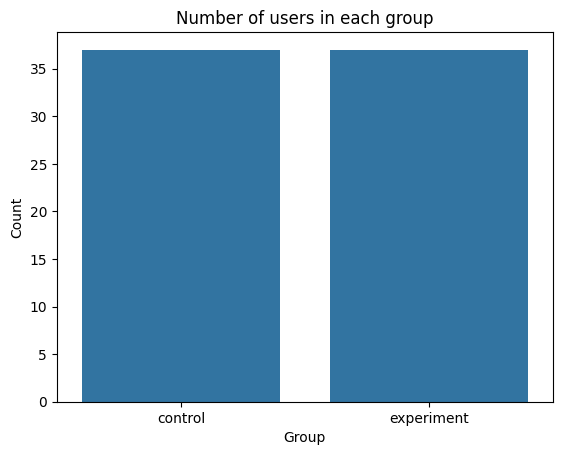

In [18]:
sns.countplot(x="Group", data=df)
plt.title("Number of users in each group")
plt.xlabel("Group")
plt.ylabel("Count")
plt.show()

In [19]:
df.columns.tolist()

['Date', 'Pageviews', 'Clicks', 'Enrollments', 'Payments', 'Group']

In [20]:
#Group level summary
summary = df.groupby('Group')[['Pageviews', 'Clicks', 'Enrollments', 'Payments']].sum().T
summary

Group,control,experiment
Pageviews,345543.0,344660.0
Clicks,28378.0,28325.0
Enrollments,3785.0,3423.0
Payments,2033.0,1945.0


**Explanation**

Here, we have two groups: control and experiment. But before doing the comparison we need to have a equivalent reference point. Because we just cannot compare the two groups directly as the sample size is different in each case.

For example:

If one group has 10000 pageviews and 1000 clicks the click-through rate (CTR) is 1000/10000= 0.1

If another group has 8000 pageviews and 960 clicks the click-through rate (CTR) is 960/8000 = 0.12

The second group has a higher CTR than the first group even though the sample size is smaller.
So, with the help of conversion rates we can compare the two groups fairly.

We will have the conversion rates as follows:

**CTR = Clicks / Pageviews (What fraction of people who saw the page clicked on it)**

**Enrollment Rate = Enrollments / Clicks (What fraction of people who clicked on the page enrolled)**

**Payment Rate = Payments / Enrollments (What fraction of people who enrolled made a payment)**

In [21]:
# Conversion Metric
conv_rates = pd.DataFrame({
    "CTR (Clicks/PageViews)": df.groupby("Group")["Clicks"].sum() / df.groupby("Group")["Pageviews"].sum(),
    "Enrollment Rate (Enrollments/Clicks)": df.groupby("Group")["Enrollments"].sum() / df.groupby("Group")["Clicks"].sum(),
    "Payment Rate (Payments/Enrollments)": df.groupby("Group")["Payments"].sum() / df.groupby("Group")["Enrollments"].sum(),
})
conv_rates

,CTR (Clicks/PageViews),Enrollment Rate (Enrollments/Clicks),Payment Rate (Payments/Enrollments)
Group,,,
control,0.082126,0.133378,0.537120
experiment,0.082182,0.120847,0.568215


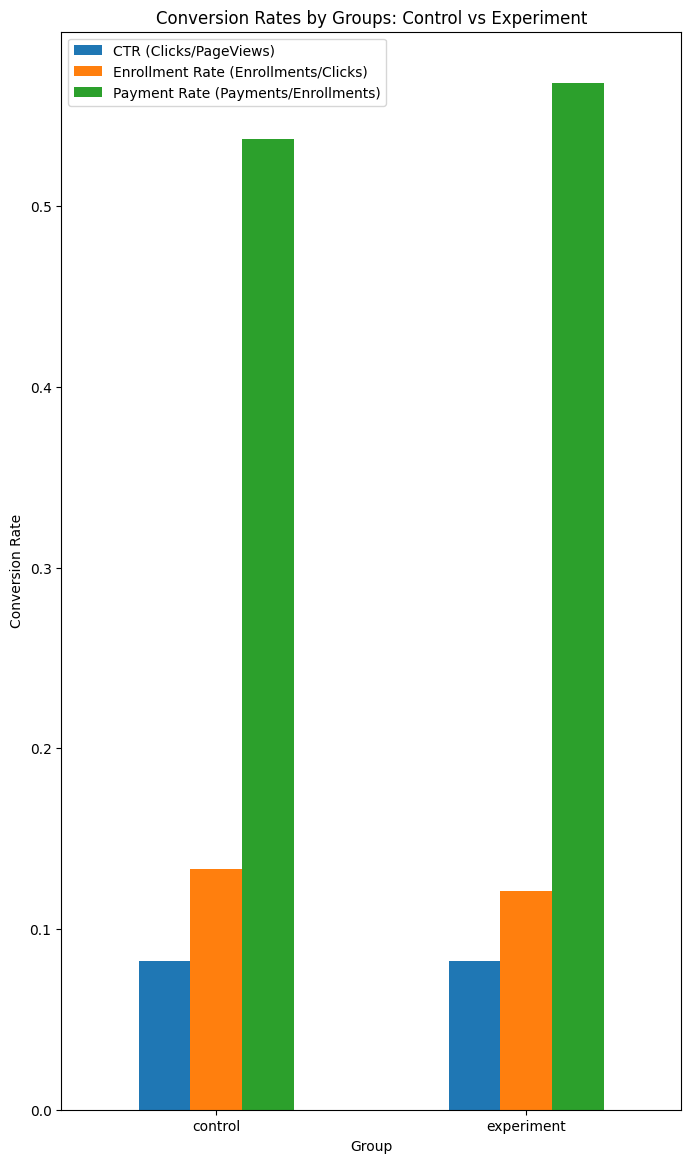

In [22]:
# Visualize the conversion rates
conv_rates.plot(kind="bar", figsize=(8, 14))
plt.title("Conversion Rates by Groups: Control vs Experiment")
plt.ylabel("Conversion Rate")
plt.xticks(rotation=0)
plt.legend(loc="upper left")
plt.show()

**My Observations:**
- The CTR is higher in the experiment group compared to the control group.
- The enrollment rate is higher in the control group compared to the experiment group.
- The payment rate is higher in the experiment group compared to the control group.

**A/B Statistical Testing**

In [23]:
from statsmodels.stats.proportion import proportions_ztest

# Prepare Totals
summary = df.groupby('Group')[['Pageviews','Clicks','Enrollments','Payments']].sum()
summary

,Pageviews,Clicks,Enrollments,Payments
Group,,,,
control,345543,28378,3785.0,2033.0
experiment,344660,28325,3423.0,1945.0


The next question is: Whether the propoertional difference (like we saw in the previous example 0.1 and 0.12) is statistically different or random noise?

To answer this question, we need to perform a statistical test. It is called a **z-test**.

The inputs are:

1) count: the number of successes (like clicks, enrollments, payments)
2) nobs: the number of observations (like pageviews, visitors)

In [24]:
# Z Test for each funnel stage

# CTR Test
clicks = summary.loc[:,'Clicks']
pageviews = summary.loc[:,'Pageviews']
z_ctr, p_ctr = proportions_ztest(count = [clicks['experiment'], clicks['control']], nobs = [pageviews['experiment'], pageviews['control']])

# Enrollment Test
enrollments = summary.loc[:,'Enrollments']
z_enroll, p_enroll = proportions_ztest(count = [enrollments['experiment'], enrollments['control']], nobs = [clicks['experiment'], clicks['control']])

# Payment Test
payments = summary.loc[:,'Payments']
z_pay, p_pay = proportions_ztest(count = [payments['experiment'], payments['control']], nobs = [enrollments['experiment'], enrollments['control']])

#Show results
pd.DataFrame({
    'Metric': ['CTR', 'Enrollment Rate', 'Payment Rate'],
    'Z-Score': [z_ctr, z_enroll, z_pay],
    'P-Value': [p_ctr, p_enroll, p_pay],
})


,Metric,Z-Score,P-Value
0,CTR,0.085661,0.931736
1,Enrollment Rate,-4.478832,0.000008
2,Payment Rate,2.650928,0.008027


Interpreting results:

The p-values:

If p < 0.05, the difference is statistically significant.

If p ≥ 0.05, the difference is not significant could be random noise.

So with the results from the z-test, we can say that:

1. The P-value in CTR is 0.931736 which is ≥ 0.05. Therefore, the difference might be random noise.
2. The P-value in Enrollment Rate is 0.000008 < 0.05. Here we can say that the experiment improved the enrollment rate.
3. The P-value in Payment Rate is 0.008027 < 0.05. Here we can say that the experiment improved the payment rate as well.

This way we can answer questions such as 
“Should we launch this new design if it increases clicks but reduces enrollments?”

**Applying CUPED**

CUPED (Controlled Using Pre-Experiment Data) is a variance reduction technique that uses users’ pre-experiment behavior to adjust post-experiment outcomes.
It keeps the average treatment effect the same but reduces noise, helping detect smaller differences more reliably.

In [26]:
# Simulate pre-experiment pageviews
import numpy as np

np.random.seed(42)
df['pageviews_prev'] = df['Pageviews'] * (0.8 + 0.2 * np.random.randn(len(df)))

# Calculate theta 
covariate = df['pageviews_prev']
outcome = df['Pageviews']
theta = np.cov(covariate, outcome)[0, 1] / np.var(covariate)
theta


np.float64(0.17585465104288933)

In [27]:
df['pageviews_cuped'] = df['Pageviews'] - theta * df['pageviews_prev'] - df['Pageviews'].mean()


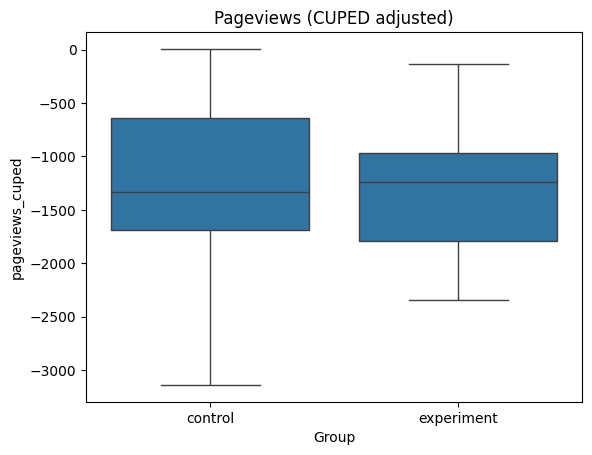

Group
control      -1250.76572
experiment   -1328.04364
Name: pageviews_cuped, dtype: float64

In [29]:
import matplotlib.pyplot as plt
sns.boxplot(x='Group', y='pageviews_cuped', data=df)
plt.title("Pageviews (CUPED adjusted)")
plt.show()

df.groupby('Group')['pageviews_cuped'].mean()

In [30]:
from statsmodels.stats.weightstats import ztest

control_vals = df[df['Group']=='control']['pageviews_cuped']
exp_vals = df[df['Group']=='experiment']['pageviews_cuped']

z_cuped, p_cuped = ztest(exp_vals, control_vals)
print(f"Z-score: {z_cuped:.3f}, p-value: {p_cuped:.5f}")


Z-score: -0.515, p-value: 0.60681


**Conclusion**

Since p > 0.05, the difference between control and experiment is not statistically significant — even after removing noise.

That means:

CUPED confirms that there’s no real measurable improvement caused by the experiment.